# Newton's Method for Optimization


Newton's method can be used to find a local minimum or maximum of a function $f(x)$. To find the extrema of a function, we replace $f$ with $f'$ and $f'$ with $f''$ in Newton's root-finding method. The iteration formula is

\begin{equation}
x_{n+1} = x_{n} - \frac{f'(x_n)}{f''(x_n)}.
\end{equation}

**Problem**

Explain why we replace $f$ with $f'$ and $f'$ with $f''$ in Newton's root-finding method when searching for extrema.

<details>
<summary>Solution</summary>

At a local minimum or maximum, the derivative $f'(x) = 0$. Therefore, finding an extremum is equivalent to finding a root of $f'(x)$.

Newton's method for finding a root of a function $g(x)$ uses the formula

\begin{equation}
x_{n+1} = x_n - \frac{g(x_n)}{g'(x_n)}.
\end{equation}

To find where $f'(x) = 0$, we set $g(x) = f'(x)$. Then $g'(x) = f''(x)$, and Newton's formula becomes

\begin{equation}
x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)}.
\end{equation}

Thus, we are applying Newton's root-finding method to the derivative $f'(x)$, which requires us to use the second derivative $f''(x)$.

</details>

The method can be extended to multiple dimensions

\begin{equation}
\mathbf{x}_{n+1} = \mathbf{x}_n - H_f(\mathbf{x}_n)^{-1} \nabla f(\mathbf{x}_n)
\end{equation}

where
* $\nabla f(\mathbf{x})$ is the **gradient** (first derivative)
* $H_f(\mathbf{x})$ is the **Hessian matrix** (second derivative for multidimensional problems)

The Hessian matrix is

\begin{equation}
H_f(\mathbf{x}) =
\begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}.
\end{equation}

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import HTML

from jax import grad, hessian 
import jax.numpy as jnp
from functools import partial 

Here is Newton method for root finding code. 

In [2]:
def newtons_method(f, x0, max_iter=1000, tol=1e-6, monitor=False):
    """
    Newton's method for optimization using JAX automatic differentiation.
    
    Parameters
    ----------
    f : callable
        Objective function to minimize
    x0 : array_like
        Initial guess
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    monitor : bool
        If True, return history of function values
    
    Returns
    -------
    x_min : ndarray
        Estimated minimum point
    loss : list (optional)
        History of function values if monitor=True
    """
    x = jnp.array(x0, dtype=float)
    
    # Gradient and Hessian functions via JAX
    df = grad(f) 
    ddf = hessian(f)
    
    if monitor:
        loss = [f(x)]
    
    # Newton's method loop
    for i in range(max_iter):
        # Evaluate gradient and Hessian
        grad_val = df(x)
        hess_val = ddf(x)
        
        # Newton's update: solve H*delta = -grad for delta
        delta_x = jnp.linalg.solve(hess_val, -grad_val)
        x_new = x + delta_x
        
        if monitor:
            loss.append(f(x_new))
        
        # Check convergence
        if jnp.linalg.norm(delta_x) < tol:
            print(f"Converged in {i+1} iterations")
            if monitor:
                return x_new, loss
            else:
                return x_new
        
        x = x_new
    
    print(f"Did not converge within {max_iter} iterations")
    
    if monitor:
        return x, loss
    else:
        return x

**Example: Solving a Nonlinear System Using Least Squares**

Consider finding the solution to the nonlinear system, a function I got from Wikipedia, 

\begin{equation}
\begin{cases}
f_0 = 3x_0 - \cos(x_1 x_2) - \frac{3}{2} = 0 \\
f_1 = 4x_0^2 - 625x_1^2 + 2x_1 - 1 = 0 \\
f_2 = e^{-x_0 x_1} + 20x_2 + \frac{10\pi - 3}{3} = 0
\end{cases}
\end{equation}

We can solve this using Newton's optimization method by minimizing the objective function

\begin{equation}
g(\mathbf{x}) = \frac{1}{2} \mathbf{F} \cdot \mathbf{F} = \frac{1}{2}\sum_{i=0}^{2} f_i^2,
\end{equation}

where $\mathbf{F} = [f_0, f_1, f_2]^T$.

Minimizing $g(\mathbf{x})$ is equivalent to minimizing the squared norm $\|\mathbf{F}\|^2$. 

In [3]:
def wiki_func(z):
    x0, x1, x2 = z
    
    f0=3*x0 - jnp.cos(x1*x2) - 3/2
    f1=4*x0**2 - 625*x1**2 + 2*x1 - 1
    f2=jnp.exp(-x0*x1) + 20*x2 + (10*jnp.pi-3)/3
    
    return jnp.array([f0, f1, f2]) 

def objective(z):
    
    f=wiki_func(z)
    
    return jnp.dot(f,f)/2.0

In [4]:
x, loss_newton=newtons_method(objective, jnp.ones(3), monitor=True) 
print("Solution and objective", x, objective(x)) 

Converged in 23 iterations
Solution and objective [ 0.8331966   0.05494366 -0.5213615 ] 7.1054274e-15


In [5]:
# check solution
wiki_func(x) 

Array([0.0000000e+00, 1.1920929e-07, 0.0000000e+00], dtype=float32)

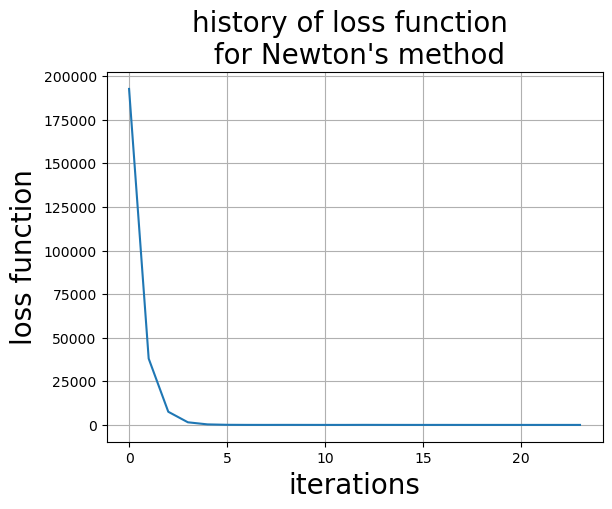

In [6]:
ax=plt.subplot()
ax.set_title("history of loss function \n for Newton's method", size=20) 
ax.set_xlabel("iterations", size=20) 
ax.set_ylabel("loss function", size=20) 
ax.plot(loss_newton) 
ax.grid()

**Example**
Minimize the Rosenbrock function
\begin{equation} 
(1-x)^2 + 100(y-x^2)^2,
\end{equation} 
which has a minima at $(x,y)=(1,1)$. 
How does Newton's method do? 

In [7]:
def rosenbrock(X):
    # minima at 1,1
    x, y = X
    return (1 - x)**2 + 100 * (y - x**2)**2

In [8]:
x, loss_newton=newtons_method(rosenbrock, jnp.ones(2)*10, monitor=True) 
print("Solution and objective", x, rosenbrock(x)) 

Converged in 6 iterations
Solution and objective [1. 1.] 0.0


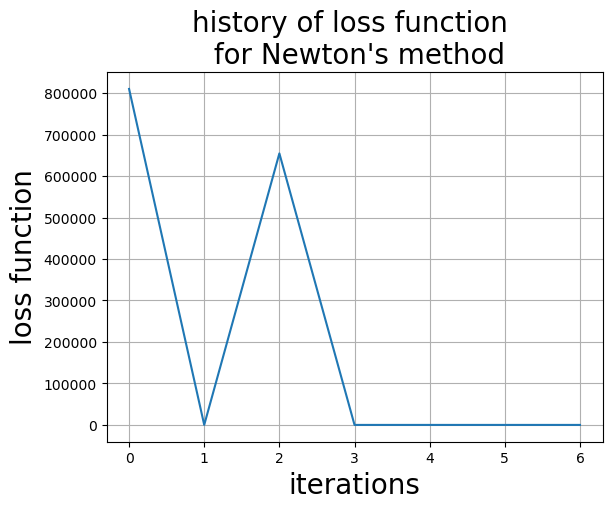

In [9]:
ax=plt.subplot()
ax.set_title("history of loss function \n for Newton's method", size=20) 
ax.set_xlabel("iterations", size=20) 
ax.set_ylabel("loss function", size=20) 
ax.plot(loss_newton) 
ax.grid()

**Example**
Try Newton's method on the [Rastrigin function](https://en.wikipedia.org/wiki/Rastrigin_function). The Rastrigin function is non-convex and has many local minima, with a global minima at $(x,y)=(0,0)$.  

\begin{equation} 
f(x,y)= 20 + x^2 + y^2 - 10 (\cos(2 \pi x) +\cos(2 \pi y))
\end{equation} 

In [10]:
def rastrigin(X):
    #minima at 0, 0
    # many local minima 
    x, y = X
    return 20 + x**2 + y**2 - 10 * (jnp.cos(2 * jnp.pi * x) + jnp.cos(2 * jnp.pi * y))


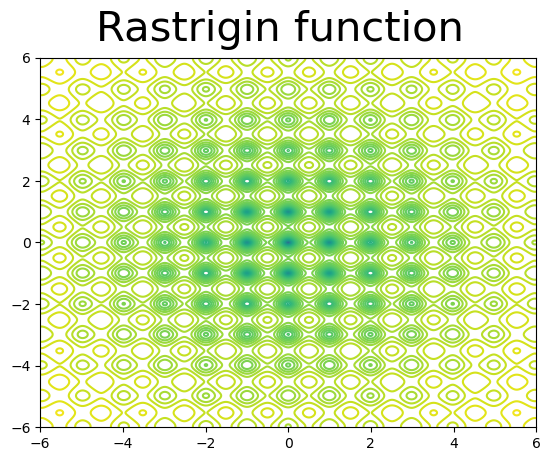

In [11]:
x=np.linspace(-6,6,1000)
y=np.linspace(-6,6,1000) 

fig=plt.figure()
fig.suptitle("Rastrigin function", size=30) 
ax=fig.add_subplot()

X,Y=np.meshgrid(x,y)
Z=rastrigin([X,Y]) 
ax.contour(X,Y,np.log(Z), levels=50) 

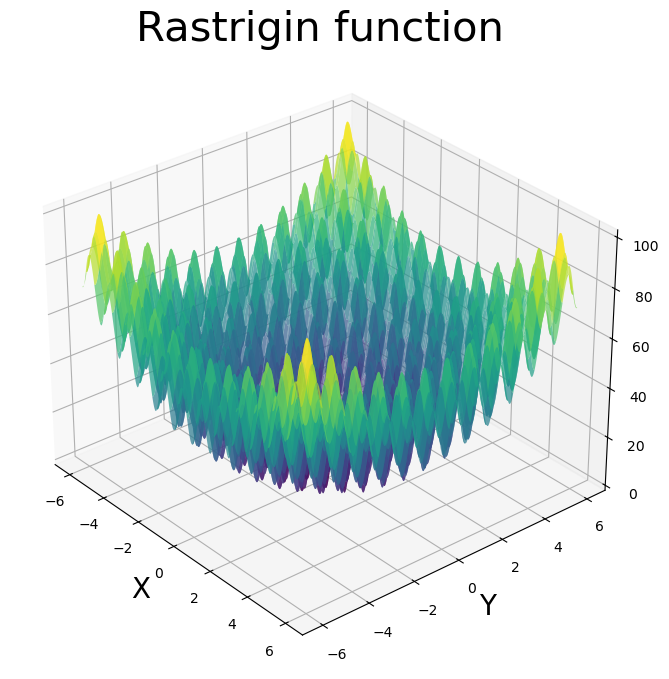

In [12]:
X, Y = np.meshgrid(x, y) 

Z = rastrigin([X,Y]) 

# Create the figure and axes object
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=.7)

# Set labels and title
ax.set_xlabel('X', size=20)
ax.set_ylabel('Y', size=20)
ax.set_title('Rastrigin function', size=30 )
ax.view_init(azim=-40) 


In [13]:
x, loss_newton=newtons_method(rastrigin, jnp.ones(2)*5, tol=1e-10,monitor=True) 
print("Solution and objective", x, rastrigin(x)) 

Did not converge within 1000 iterations
Solution and objective [4.9746914 4.9746914] 49.747444


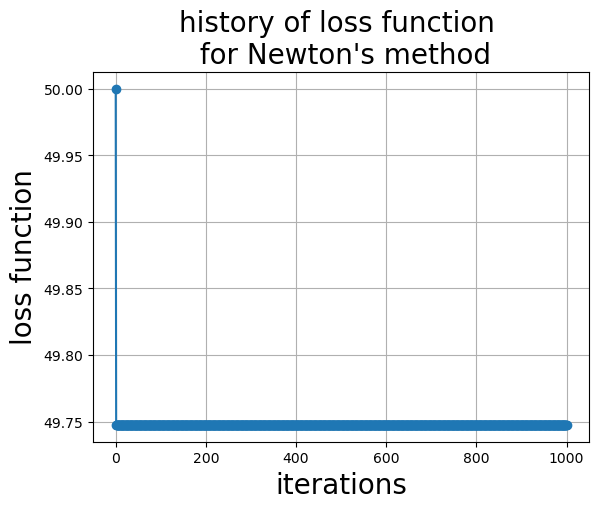

In [14]:
ax=plt.subplot()
ax.set_title("history of loss function \n for Newton's method", size=20) 
ax.set_xlabel("iterations", size=20) 
ax.set_ylabel("loss function", size=20) 
ax.plot(loss_newton, "-o") 
ax.grid()

**Question**
How did Newton's method perform on the Rastrigin function? Did it find the global minima? Explain what happened. Can you think of anything you could do to help improve the result? 

<details>
<summary>Answer</summary>
Newton's method got stuck in one of the many local minima. Local minima = "it's a trap."
</details>